In [31]:
import kagglehub
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset from KaggleHub
path = kagglehub.dataset_download("wcukierski/enron-email-dataset")

df = pd.read_csv(f"{path}/emails.csv", nrows=15000)



In [32]:

pd.set_option('display.max_colwidth', None)

In [33]:
print(df.shape)

(15000, 2)


In [34]:
df.iloc[2]

file                                                                                                                                                                                                                                                                                                                                                                                                                                                                              allen-p/_sent_mail/100.
message    Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>\nDate: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: leah.arsdall@enron.com\nSubject: Re: test\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Leah Van Arsdall\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\ntest successful.  way to go!!!
Name: 2, dtype: obje

In [35]:
df.head

<bound method NDFrame.head of                                  file  \
0               allen-p/_sent_mail/1.   
1              allen-p/_sent_mail/10.   
2             allen-p/_sent_mail/100.   
3            allen-p/_sent_mail/1000.   
4            allen-p/_sent_mail/1001.   
...                               ...   
14995  bass-e/discussion_threads/822.   
14996  bass-e/discussion_threads/823.   
14997  bass-e/discussion_threads/824.   
14998  bass-e/discussion_threads/825.   
14999  bass-e/discussion_threads/826.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [36]:
df.describe()

,file,message
count,15000,15000
unique,15000,15000
top,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n"
freq,1,1


In [37]:
df.isna().sum()

file       0
message    0
dtype: int64

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     15000 non-null  object
 1   message  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


Features:
days_until_event
unsubscribe_present
participant_count
urgency_score
attachment_type
has_money
academic_words

In [ ]:
import re
from datetime import datetime as dt
import dateparser
from dateparser.search import search_dates
import email 
# Email parsing function 

def parse_email(raw_email):
    """
    Parses raw email string into an email.message.EmailMessage object
    """
    # Return empty fields if row is not a string

    if not isinstance(raw_email, str):
        return {
            "subject": '', "sender": '', "date": '', 
            "to": '', "cc": '', "bcc": '', 
            "body": '', "headers": ''
        }
    
    msg = email.message_from_string(raw_email)
    raw_headers = str(msg.items())
    
    body_content = ""

    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == "text/plain":

                body_content += part.get_payload(decode=True).decode('utf-8', errors='ignore')
                
    else: 
        body_content = msg.get_payload(decode=True).decode('utf-8', errors='ignore')
    
    return {
       "subject": msg.get("Subject", ''),
        "sender": msg.get("From", ''),
        "date": msg.get("Date", ''), 
        "to": msg.get("To", ''), 
        "cc": msg.get("Cc", ''), 
        "bcc": msg.get("Bcc", ''), 
        "body": body_content,
        "headers": raw_headers
    }

parsed_data = df['message'].apply(parse_email).apply(pd.Series)

df = pd.concat([df, parsed_data], axis=1)
print(df[['subject', 'sender']].head())

     subject                   sender
0             phillip.allen@enron.com
1        Re:  phillip.allen@enron.com
2   Re: test  phillip.allen@enron.com
3             phillip.allen@enron.com
4  Re: Hello  phillip.allen@enron.com


In [54]:
# Feature engineering functions

def get_days_until_event(text):
    """ 
    Scans text using dateparser to find the closest future date 
    and returns how many days away it is
    """
    # Ensure that text is a string
    if not isinstance(text, str): return 999

    now = dt.now()
    extracted_dates = search_dates(text, languages=['en'], settings={'PREFER_DATES_FROM': 'future'})

    if not extracted_dates: 
        return 999 #default for no date found
    
    future_dates = []
    for date_tuple in extracted_dates:
        found_date = date_tuple[1]
        found_date = found_date.replace(tzinfo=None)    
        if found_date > now:
            future_dates.append(found_date)

    if not future_dates:
        return 999
    
    # Get the soonest date
    soonest_date = min(future_dates)
    delta = soonest_date - now
    return delta.days

def check_unsubscribe_present(row):
    """
    Checks emails for 'unsubscribe', and returns one if found, else zero 
    """
    # Check header
    if "List-Unsubscribe" in row['headers']:
        return 1
    
    # Check body
    if re.search (r'unsubscribe|manage - preferences|opt-out', row['body'], re.IGNORECASE):
        return 1

    return 0 


def get_urgency_score(text):
    """
    Simple urgency score based on presence of certain keywords
    """
    # Ensure that text is a string
    if not isinstance(text, str): return 0

    urgency_keywords = ['urgent', 'asap', 'immediately', 'priority', 'important', 'attention', 'confirm', 'deadline', 'action required', 'due', 'response needed', 'follow up', 'time sensitive', 'reminder']
    score = 0
    for word in urgency_keywords:
        if word in text.lower():
            score += 1
    return score

def get_participant_count(row):
    """
    Counts number of unique email addresses in To, CC, BCC
    """
    participants = set()
    for field in ['to', 'cc', 'bcc']:
        if pd.notna(row[field]):
            emails = re.findall(r'[\w\.-]+@[\w\.-]+', row[field])
            participants.update(emails)

    return len(participants)

def get_research_score(text):
    """
    Simple research score based on presence of certain keywords
    """
    research_keywords = ['research', 'study', 'analysis', 'data', 'findings', 'report', 'survey', 'experiment', 'results']
    score = 0

   
    for word in research_keywords:
        if word in text.lower():
            score += 1 
    return score

df = df.loc[:, ~df.columns.duplicated()]

# Applying features
df['combined_text'] = df['subject'].fillna('') + " " + df['body'].fillna('')

df['unsubscribe_present'] = df.apply(check_unsubscribe_present, axis=1)
df['days_until_event'] = df['combined_text'].apply(get_days_until_event)
df['urgency_score'] = df['combined_text'].apply(get_urgency_score)
df['research_score'] = df['combined_text'].apply(get_research_score)
df['participant_count'] = df.apply(get_participant_count, axis=1)

# Check results
print(df.head())

KeyboardInterrupt: 

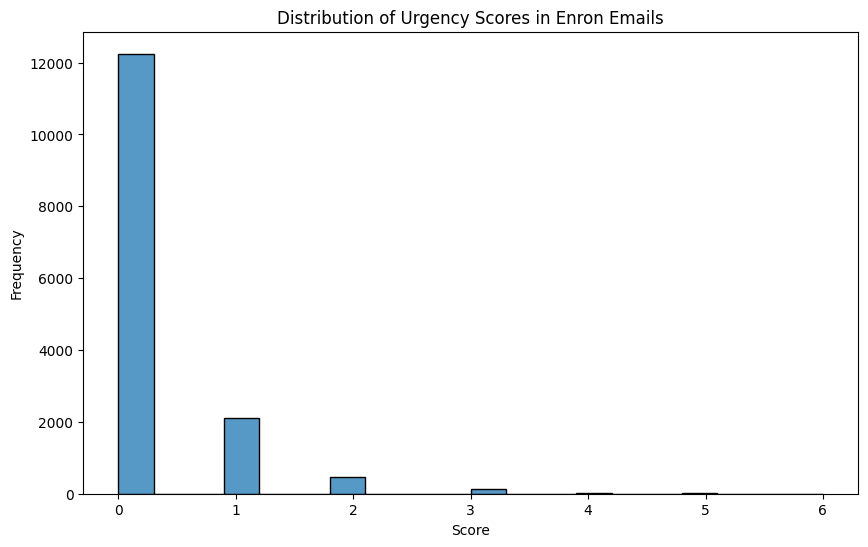

In [49]:
# Visualization

plt.figure(figsize=(10, 6))
sns.histplot(df['urgency_score'], bins=20, kde=False)
plt.title('Distribution of Urgency Scores in Enron Emails')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

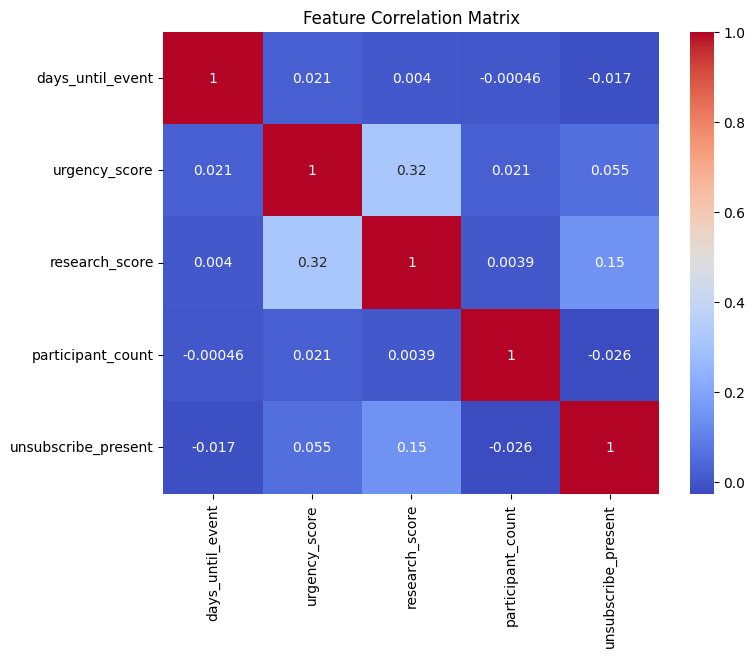

In [46]:
numeric_df = df[['days_until_event', 'urgency_score', 'research_score', 'participant_count', 'unsubscribe_present']]
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [47]:
# Hueristic classifier to solve cold start problem

def heuristic_classifier(row):
    """
    Classifies email urgency based on engineered features
    """
    if row['days_until_event'] < 7:
        return "Important"
    
    if row ['urgency_score'] > 0 or row['research_score'] > 0:
        return "Important"
    
    if row['participant_count'] > 5 and row['urgency_score'] > 0:
        return "Important"
    
    if row['unsubscribe_present'] == 1:
        return "Archive"
    
    if row['participant_count'] > 5 and row['urgency_score'] == 0:
        return "Archive"
    
    else: 
        return "Archive"

# Applying heuristic classifier
df['label'] = df.apply(heuristic_classifier, axis=1)
print(df['label'].value_counts())

label
Archive      8623
Important    6377
Name: count, dtype: int64


Random Forest Classifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1756
           1       1.00      1.00      1.00      1244

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



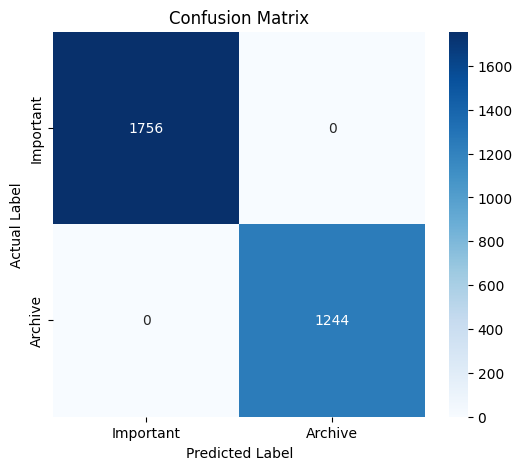

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Modeling 

feature_cols = ['days_until_event', 'urgency_score', 'research_score', 'participant_count', 'unsubscribe_present']
X = df[feature_cols]
le = LabelEncoder()
y = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Important', 'Archive'], 
            yticklabels=['Important', 'Archive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()




Logistic Regression Accuracy: 0.8803333333333333
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1756
           1       1.00      0.71      0.83      1244

    accuracy                           0.88      3000
   macro avg       0.92      0.86      0.87      3000
weighted avg       0.90      0.88      0.88      3000



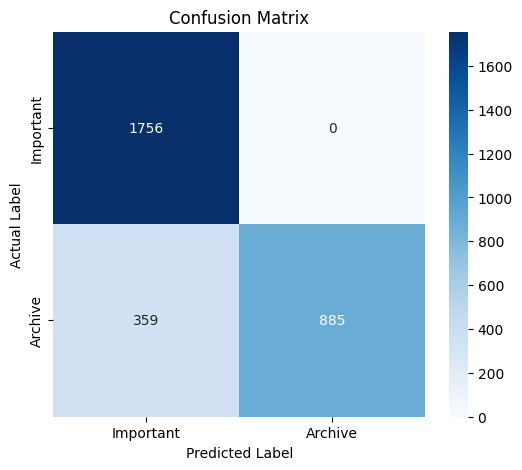

In [64]:
# Linear regression

lin_model = LogisticRegression(max_iter=200)
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin))


cm = confusion_matrix(y_test, y_pred_lin)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Important', 'Archive'], 
            yticklabels=['Important', 'Archive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
